In [2]:
import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt

# we will use astropy for some useful constants and units 
from astropy import units as u
from astropy import constants as const

In [3]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

In [3]:
def load_data(ns_kicks, sigmas):    
    SN_KICK_BH_ALL = []
    SN_KICK_NS_ALL = []
    NS_KICK_MULT = []
    SIGMAS = []
       
    
    for ns_kick in ns_kicks:
        for sigma in sigmas:
            path = os.environ['WORK'] + f'/supernova_remnant_bse/bh_{bh_kick}_ns_{ns_kick}_sigma_{sigma}_combined.h5'
            print("loading data from", path)
            
            fdata = h5.File(path, 'r')
            
            SN_STELLAR_TYPE = fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
            SN_TYPE = fdata['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
            SN_KICK = fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][...].squeeze()

            maskSN_NS = ((SN_STELLAR_TYPE ==13) * (SN_TYPE == 1)) # select NSs, ignore electron capture SN
            maskSN_BH = ((SN_STELLAR_TYPE ==14) * (SN_TYPE == 1)) # select BHs, ignore electron capture SN
            
            SN_KICK_NS = SN_KICK[maskSN_NS]
            SN_KICK_BH = SN_KICK[maskSN_BH] 

            fdata.close()
            
            SN_KICK_NS_ALL.append(SN_KICK_NS)
            SN_KICK_BH_ALL.append(SN_KICK_BH)
            NS_KICK_MULT.append(ns_kick)
            SIGMAS.append(sigma)
            
    return SN_KICK_NS_ALL, SN_KICK_BH_ALL, NS_KICK_MULT, SIGMAS


In [11]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


# Load in the data files

In [5]:
bh_kick = 200
ns_kicks = [500]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

SN_KICK_NS_ALL, SN_KICK_BH_ALL, NS_KICK_MULT, SIGMAS = load_data(ns_kicks, sigmas)

loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.1_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.2_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.3_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.4_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.5_combined.h5


In [6]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [7]:
print(kick_models["NS_500_RANGE"])
# print(kick_models["NS_350_RANGE"])
# print(kick_models["NS_450_RANGE"])

[0 1 2 3 4]


In [8]:
print(kick_models["SIGMA_0.1_RANGE"])
print(kick_models["SIGMA_0.2_RANGE"])
print(kick_models["SIGMA_0.3_RANGE"])
print(kick_models["SIGMA_0.4_RANGE"])
print(kick_models["SIGMA_0.5_RANGE"])

print(kick_models["ALL"])

[0]
[1]
[2]
[3]
[4]
[0 1 2 3 4]


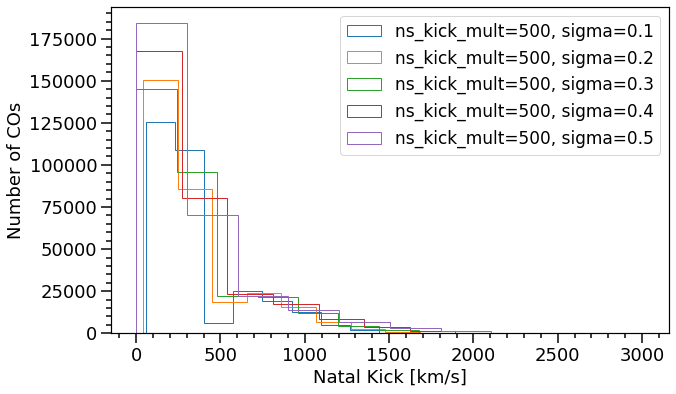

In [12]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

PLOT_RANGE = kick_models["NS_500_RANGE"]
# PLOT_RANGE = np.intersect1d(kick_models["NS_300_RANGE"], kick_models["SIGMA_0.3_RANGE"])
# PLOT_RANGE = kick_models["ALL"]

for i in PLOT_RANGE:
    plt.hist(SN_KICK_NS_ALL[i], label=f'ns_kick_mult={NS_KICK_MULT[i]}, sigma={SIGMAS[i]}', histtype='step');

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='Number of COs')
plt.legend(fontsize=17)
plt.show()

In [13]:
def plot_kde(PLOT_RANGE):
    f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
    
    for i in PLOT_RANGE:
        kde_NS = gaussian_kde( SN_KICK_NS_ALL[i] )
        NS_dist_space = linspace( min(SN_KICK_NS_ALL[i]), max(SN_KICK_NS_ALL[i]), 100 )

        plt.plot( NS_dist_space, kde_NS(NS_dist_space), label=f'ns_kick_mult={NS_KICK_MULT[i]}, sigma={SIGMAS[i]}');

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [km/s ^-1]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=17)
    plt.show()


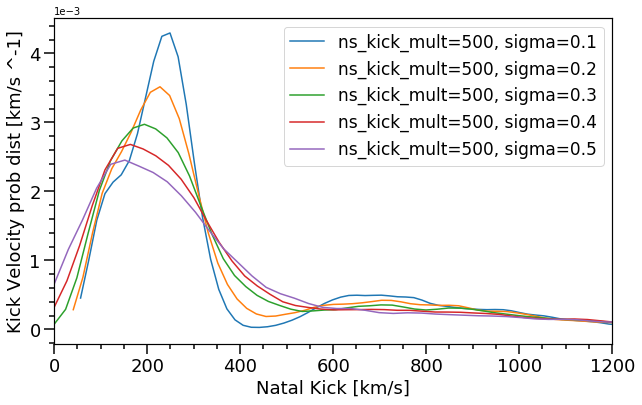

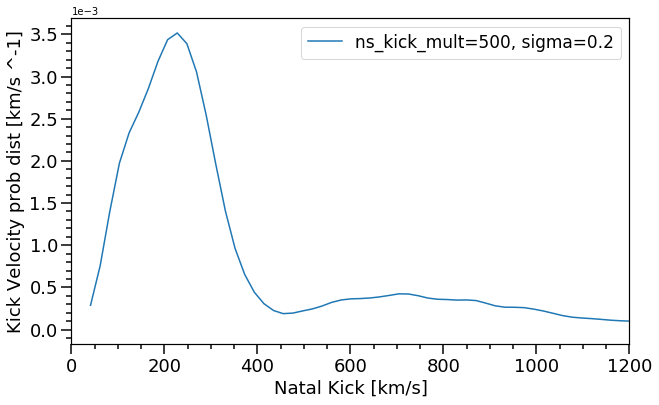

In [14]:
plot_kde(kick_models["NS_500_RANGE"])
plot_kde(kick_models["SIGMA_0.2_RANGE"])

# Investigate the difference between SSE and BSE kicks

## BSE Data

In [4]:
path = os.environ['WORK']+'/supernova_remnant_bse/bh_200_ns_400_sigma_0.4_combined.h5'
fdata_bse = h5.File(path, 'r')
list(fdata_bse.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_System_Parameters',
 'Run_Details']

In [5]:
BSE_SN_MASS_CORE = fdata_bse['BSE_Supernovae']["Mass_Core@CO(SN)"][...].squeeze()
BSE_SN_MASS_CO = fdata_bse['BSE_Supernovae']["Mass_CO_Core@CO(SN)"][...].squeeze()

BSE_SN_MASS_REM = fdata_bse['BSE_Supernovae']["Mass(SN)"][...].squeeze()
BSE_SN_STELLAR_TYPE = fdata_bse['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
BSE_SN_TYPE = fdata_bse['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 

BSE_SN_STELLAR_TYPE_PREV = fdata_bse['BSE_Supernovae']["Stellar_Type_Prev(SN)"][...].squeeze()


BSE_UNBOUND  = fdata_bse['BSE_Supernovae']["Unbound"][...].squeeze() 

BSE_CP_STELLAR_TYPE =fdata_bse['BSE_Supernovae']["Stellar_Type(CP)"][...].squeeze()

# BSE_SN_KICK = fdata_bse['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][...].squeeze()
BSE_SN_KICK = fdata_bse['BSE_Supernovae']["ComponentSpeed(SN)"][...].squeeze()

fdata_bse.close()

In [6]:
BSE_maskSN_NS = ((BSE_SN_STELLAR_TYPE ==13) * (BSE_SN_TYPE == 1)) * (BSE_UNBOUND == 1) # select unbound NSs, ignore electron capture SN
BSE_maskSN_BH = ((BSE_SN_STELLAR_TYPE ==14) * (BSE_SN_TYPE == 1)) * (BSE_UNBOUND == 1) # select unbound BHs, ignore electron capture SN

BSE_maskCP_NS = (BSE_CP_STELLAR_TYPE == 13)
BSE_maskCP_BH = (BSE_CP_STELLAR_TYPE == 14)
BSE_maskCP_other = (BSE_CP_STELLAR_TYPE != 13) * (BSE_CP_STELLAR_TYPE != 14)

## SSE Data

In [7]:
path = os.environ['WORK']+'/supernova_remnant_production/bh_200_ns_400_sigma_0.4_combined.h5'
fdata_sse = h5.File(path, 'r')
list(fdata_sse.keys())

['Run_Details', 'SSE_Supernovae', 'SSE_System_Parameters']

In [8]:
SSE_SN_MASS_CORE = fdata_sse['SSE_Supernovae']["Mass_Core@CO"][...].squeeze()
SSE_SN_MASS_CO = fdata_sse['SSE_Supernovae']["Mass_CO_Core@CO"][...].squeeze()

SSE_SN_MASS_REM = fdata_sse['SSE_Supernovae']["Mass"][...].squeeze()
SSE_SN_STELLAR_TYPE = fdata_sse['SSE_Supernovae']["Stellar_Type"][...].squeeze()
SSE_SN_TYPE = fdata_sse['SSE_Supernovae']["SN_Type"][...].squeeze() 

SSE_SN_STELLAR_TYPE_PREV = fdata_sse['SSE_Supernovae']["Stellar_Type_Prev"][...].squeeze()

SSE_CP_STELLAR_TYPE =fdata_sse['SSE_Supernovae']["Stellar_Type"][...].squeeze()

SSE_SN_KICK = fdata_sse['SSE_Supernovae']["Applied_Kick_Magnitude"][...].squeeze()

fdata_sse.close()

In [9]:
SSE_maskSN_NS = ((SSE_SN_STELLAR_TYPE ==13) * (SSE_SN_TYPE == 1)) # select NSs, ignore electron capture SN
SSE_maskSN_BH = ((SSE_SN_STELLAR_TYPE ==14) * (SSE_SN_TYPE == 1)) # select BHs, ignore electron capture SN

SSE_maskCP_NS = (SSE_CP_STELLAR_TYPE == 13)
SSE_maskCP_BH = (SSE_CP_STELLAR_TYPE == 14)
SSE_maskCP_other = (SSE_CP_STELLAR_TYPE != 13) * (SSE_CP_STELLAR_TYPE != 14)

## Confirm the double peak structure of BSE

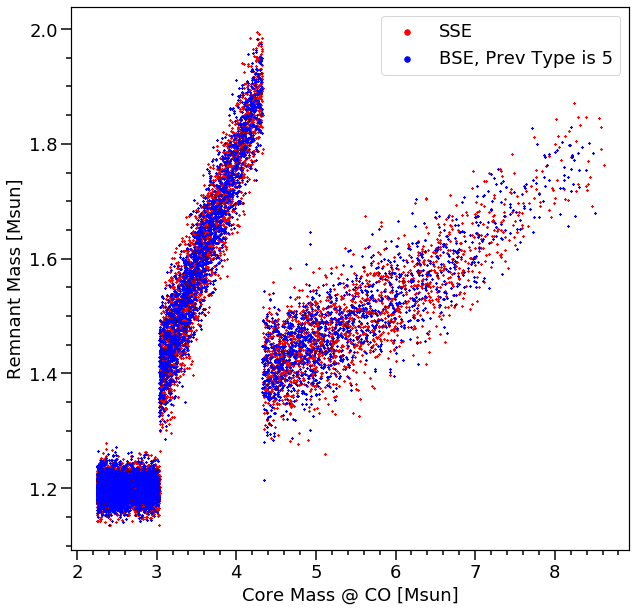

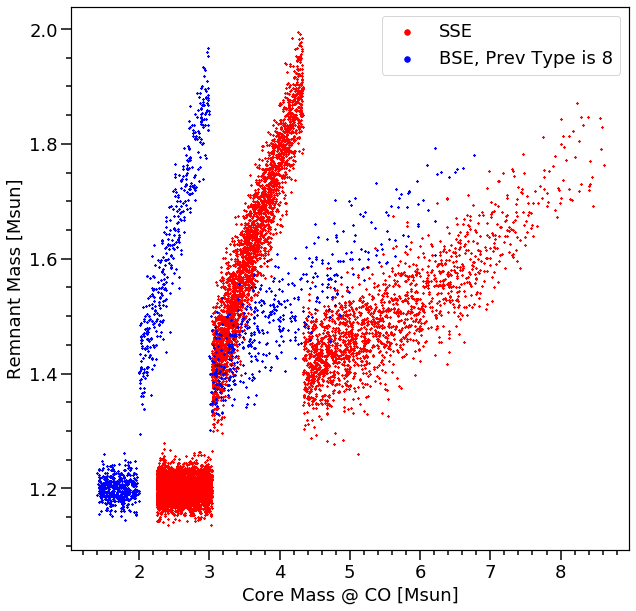

In [12]:
for i in [5,8]:
    BSE_maskPrev = (BSE_SN_STELLAR_TYPE_PREV == i)
    f, ax= plt.subplots(1, 1,  figsize=(10,10)) 
    s=0.2
    
    plt.scatter(SSE_SN_MASS_CORE[SSE_maskSN_NS], SSE_SN_MASS_REM[SSE_maskSN_NS], s=s, color='r', label='SSE')

    
    plt.scatter(BSE_SN_MASS_CORE[BSE_maskSN_NS*BSE_maskPrev], BSE_SN_MASS_REM[BSE_maskSN_NS*BSE_maskPrev], s=s, color='b', label=f'BSE, Prev Type is {i}')

    layoutAxes(ax=ax, nameX='Core Mass @ CO [Msun]',\
               nameY='Remnant Mass [Msun]')

    lgnd = plt.legend(scatterpoints=1, fontsize=18)
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]

    plt.show()

It looks like the SSE scenario is identical in mass to the scenario where BSE stars are in the EAGB before supernova. 

In [13]:
for i in [5,8]:
    BSE_maskPrev = (BSE_SN_STELLAR_TYPE_PREV == i)
    n_sn = np.sum(BSE_maskSN_NS*BSE_maskPrev)
    n_tot = np.sum(BSE_maskSN_NS)
    print(f"Type {i}: {n_sn} (~{100*(n_sn/n_tot):.2f}%)")
    


Type 5: 237441 (~81.68%)
Type 8: 53240 (~18.32%)


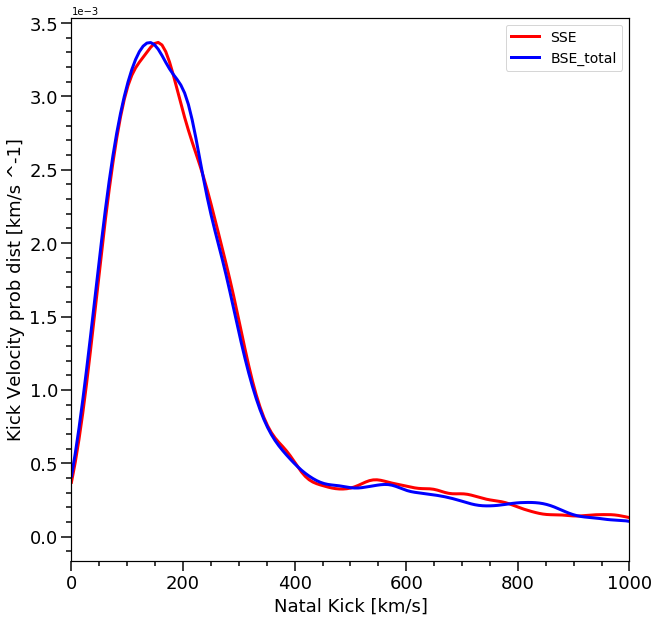

In [14]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 


kde_dist_space = linspace( min(BSE_SN_KICK), max(BSE_SN_KICK), 300 )

kde_SSE = gaussian_kde( SSE_SN_KICK[SSE_maskSN_NS] )

kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS] )
kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS*(BSE_SN_STELLAR_TYPE_PREV==(5 or 8)) ] )



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

plt.plot( kde_dist_space, kde_SSE(kde_dist_space), c='r', lw=3, label='SSE')
plt.plot( kde_dist_space, kde_BSE_total(kde_dist_space), c='b', lw=3, label='BSE_total')


plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.show()

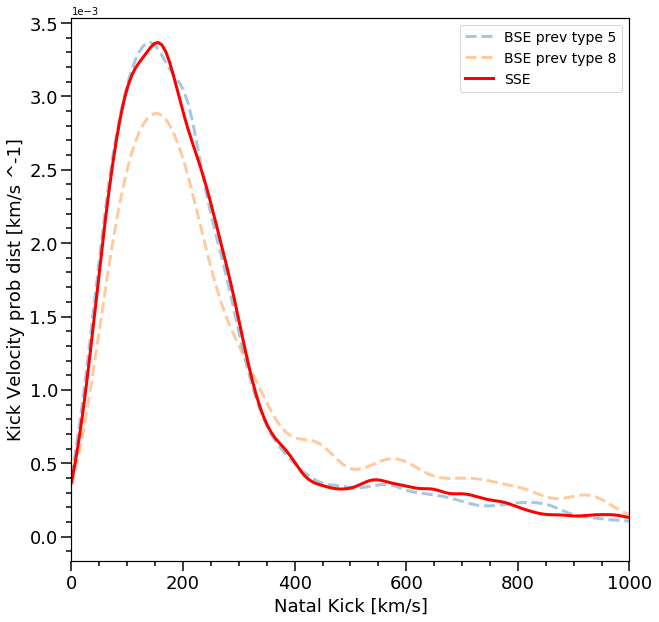

In [16]:
f, ax= plt.subplots(1, 1,  figsize=(10,10)) 

for i in [5,8]:
    BSE_maskPrev = (BSE_SN_STELLAR_TYPE_PREV == i)    
    kde_BSE = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS*BSE_maskPrev] )
    
    kde_dist_space = linspace( min(BSE_SN_KICK), max(BSE_SN_KICK), 300 )

    plt.plot( kde_dist_space, kde_BSE(kde_dist_space), '--', lw=3, alpha=0.4, label=f'BSE prev type {i}')

kde_SSE = gaussian_kde( SSE_SN_KICK[SSE_maskSN_NS] )

# kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS] )
kde_BSE_total = gaussian_kde( BSE_SN_KICK[BSE_maskSN_NS*(BSE_SN_STELLAR_TYPE_PREV==(5 or 8)) ] )



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
       nameY='Kick Velocity prob dist [km/s ^-1]')

plt.plot( kde_dist_space, kde_SSE(kde_dist_space), c='r', lw=3, label='SSE')
# plt.plot( kde_dist_space, kde_BSE_total(kde_dist_space), c='b', lw=3, label='BSE_total')


plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlim(0,1000)
plt.legend(fontsize=14)

plt.show()

Evidently, both cases produce velocity peaks that are slightly to the left of the SSE case, so this double peak quirk cannot explain why BSE velocities differ slightly from SSE velocities.
My current theory is that (as Ilya suggested) BSE just acts to increase the $\sigma_{ns}$ parameter because it adds some stochastic variation to the velocities around the SSE values. Therefore, the BSE curve has its peak shifted to the left, and tail shifted to the right, which is the behavior we see when we hold $v_{ns}$ constant and increase $\sigma_{ns}$.